Available columns in the dataset:
['Semester', 'InfoVeranstaltung', 'Immatrikulation', 'Zweitbewerbung', 'Geschlecht', 'HZB-Art', 'Note HZB', 'Note Bachelor', 'ECTS Bachelor', 'Fachrichtung Bachelor', 'Distance_to_71034']

Logistic Regression Results:
Accuracy: 0.8621
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       0.89      0.89      0.89        19

    accuracy                           0.86        29
   macro avg       0.85      0.85      0.85        29
weighted avg       0.86      0.86      0.86        29

Confusion Matrix:
[[ 8  2]
 [ 2 17]]

Random Forest Results:
Accuracy: 0.8276
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.70      0.74        10
           1       0.85      0.89      0.87        19

    accuracy                           0.83        29
   macro avg       0.81      0.80      0.80        29
weighted

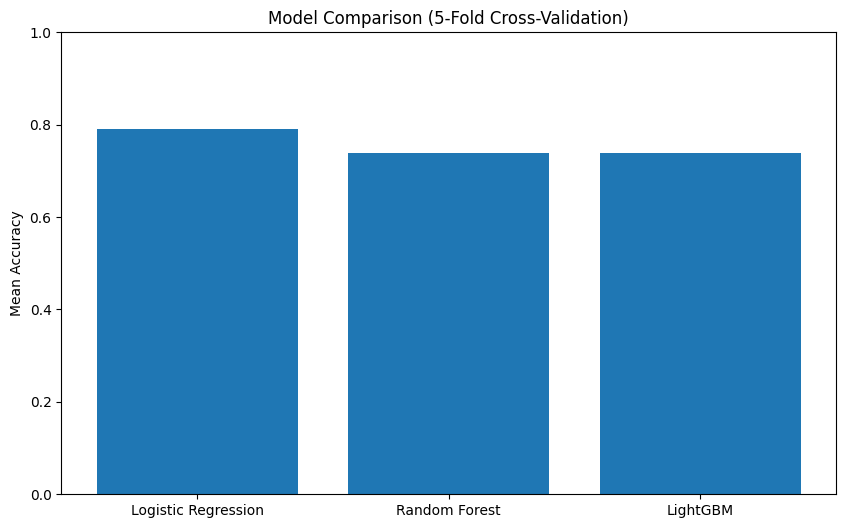

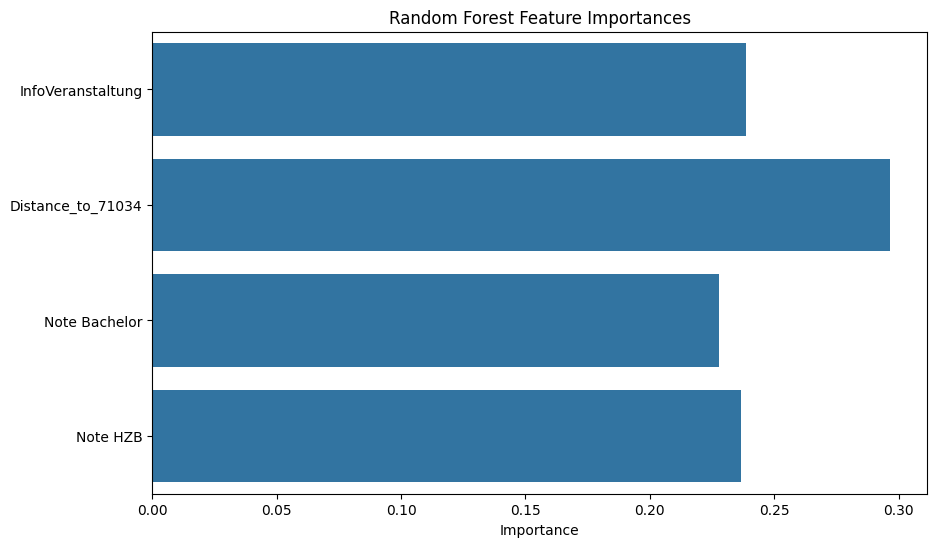

[LightGBM] [Info] Number of positive: 36, number of negative: 31
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000016 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57
[LightGBM] [Info] Number of data points in the train set: 67, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.537313 -> initscore=0.149532
[LightGBM] [Info] Start training from score 0.149532
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

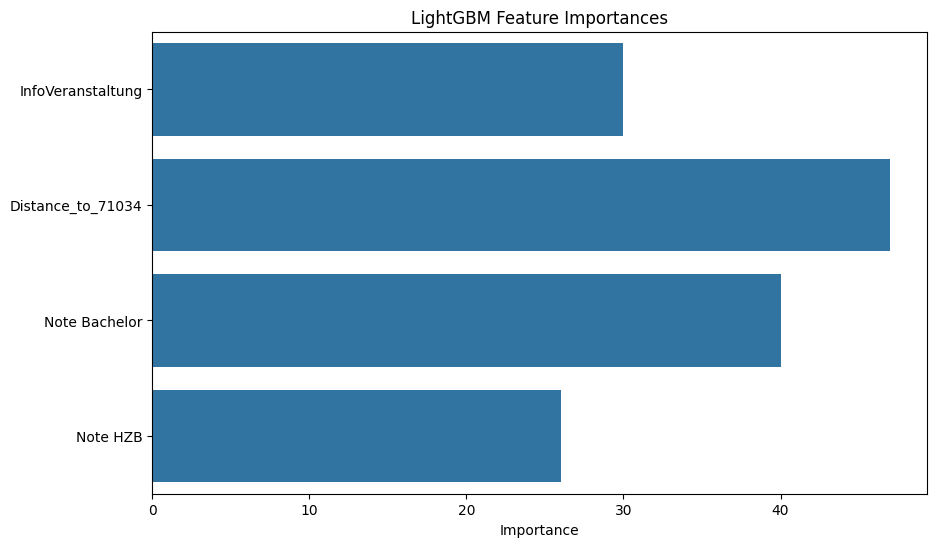

ValueError: Input X contains NaN.
LogisticRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
data = pd.read_excel('data_with_distances.xlsx', header=0)

# Print available columns
print("Available columns in the dataset:")
print(data.columns.tolist())

# Set the target column
target_column = 'Immatrikulation'

# Preprocess the data
# Convert binary columns to numeric
binary_columns = ['InfoVeranstaltung', 'Immatrikulation', 'Zweitbewerbung']
for col in binary_columns:
    data[col] = data[col].map({'Ja': 1, 'Nein': 0, 'ja': 1, 'nein': 0})

# Convert categorical columns to numeric using LabelEncoder
categorical_columns = ['Geschlecht', 'HZB-Art', 'Fachrichtung Bachelor']
le = LabelEncoder()
for col in categorical_columns:
    data[col] = le.fit_transform(data[col].astype(str))

# Select the features we want to use
selected_features = ['InfoVeranstaltung', 'Distance_to_71034', 'Note Bachelor', 'Note HZB']

# Prepare the dataset
X = data[selected_features]
y = data[target_column]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create pipelines for each model
lr_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(random_state=42))
])

rf_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42))
])

lgb_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('lgb', lgb.LGBMClassifier(random_state=42))
])

# List of models
models = [
    ('Logistic Regression', lr_pipeline),
    ('Random Forest', rf_pipeline),
    ('LightGBM', lgb_pipeline)
]

# Function to evaluate model
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy, classification_report(y_test, y_pred), confusion_matrix(y_test, y_pred)

# Evaluate each model and store results
results = {}
for name, model in models:
    accuracy, report, cm = evaluate_model(model, X_train, X_test, y_train, y_test)
    results[name] = {
        'accuracy': accuracy,
        'report': report,
        'confusion_matrix': cm
    }
    print(f"\n{name} Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print("Classification Report:")
    print(report)
    print("Confusion Matrix:")
    print(cm)

# Perform cross-validation
cv_scores = {}
for name, model in models:
    scores = cross_val_score(model, X, y, cv=5)
    cv_scores[name] = scores.mean()
    print(f"\n{name} 5-Fold CV Score: {scores.mean():.4f} (+/- {scores.std() * 2:.4f})")

# Plot cross-validation results
plt.figure(figsize=(10, 6))
plt.bar(cv_scores.keys(), cv_scores.values())
plt.title('Model Comparison (5-Fold Cross-Validation)')
plt.ylabel('Mean Accuracy')
plt.ylim(0, 1)
plt.show()

# Feature importance plots (for Random Forest and LightGBM)
for name, model in models:
    if name in ['Random Forest', 'LightGBM']:
        model.fit(X_train, y_train)
        if name == 'Random Forest':
            importances = model.named_steps['rf'].feature_importances_
        elif name == 'LightGBM':
            importances = model.named_steps['lgb'].feature_importances_
        plt.figure(figsize=(10, 6))
        sns.barplot(x=importances, y=selected_features)
        plt.title(f'{name} Feature Importances')
        plt.xlabel('Importance')
        plt.show()

# Coefficients for Logistic Regression
lr_model = lr_pipeline.named_steps['lr']
lr_model.fit(X_train, y_train)
lr_coefficients = lr_model.coef_[0]

plt.figure(figsize=(10, 6))
sns.barplot(x=np.abs(lr_coefficients), y=selected_features)
plt.title('Logistic Regression Coefficients (Absolute Values)')
plt.xlabel('Coefficient Magnitude')
plt.show()